In [1]:
using Pkg
using PyPlot
using HDF5
using Statistics
using ProgressMeter
include("src/Schelling2D1S.jl")
using .Schelling2D1S

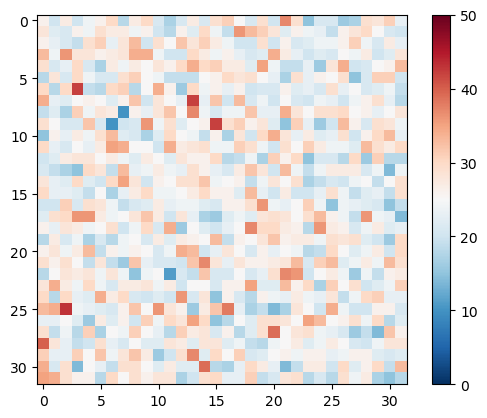

PyObject <matplotlib.colorbar.Colorbar object at 0x296d62040>

In [8]:
params = Dict("capacity" => 50,
              "temperature" => 0.01,
              "preferred_density" => 0.5,
              "m" => 0.0,
              "alpha" => 0.4,
              "n_sweeps" => 100,
              "moveType" => "local",
              "grid_size" => 32,
              "fill" => 0.5,
              "utility_func" => asymmetric_utility);

# random initial condition
state = random_state(params);
state_init = deepcopy(state)
plt.imshow(state_init,
           vmin=0,
           vmax=params["capacity"],
           cmap="RdBu_r")
plt.colorbar()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


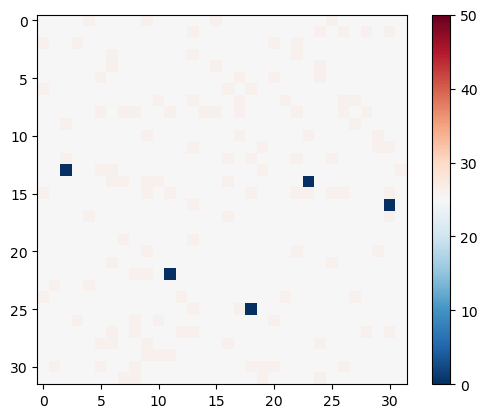

PyObject <matplotlib.colorbar.Colorbar object at 0x2976a0c70>

In [9]:
# run simulation
run_simulation!(state, params)
plt.imshow(state,
           vmin=0,
           vmax=params["capacity"],
           cmap="RdBu_r")
plt.colorbar()

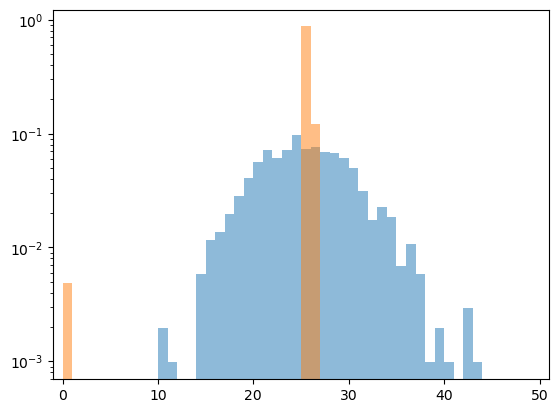

1-element Vector{Tuple{Float64, Float64}}:
 (-1.0, 51.0)

In [10]:
fig, ax = plt.subplots()
ax.hist(state_init[:], bins=0:params["capacity"], alpha=0.5, density=true, log=true);
ax.hist(state[:], bins=0:params["capacity"], alpha=0.5, density=true, log=true);
ax.set(xlim=[-1, params["capacity"] + 1])

In [7]:
plt.plot(0:params["capacity"],
         [quadratic_utility(i, params) for i in 0:params["capacity"]])
plt.plot(0:params["capacity"],
         [asymmetric_utility(i, params) for i in 0:params["capacity"]])

LoadError: MethodError: no method matching quadratic_utility(::Int64, ::Dict{String, Any})
[0mClosest candidates are:
[0m  quadratic_utility([91m::Float64[39m, ::Dict{String, Any}) at ~/code/uchicago/adaptation/diffuser/schelling/1species/monteCarlo/src/schelling.jl:245

In [ ]:
params = Dict("capacity" => 50,
              "temperature" => 0.01,
              "preferred_density" => 0.5,
              "m" => 0.0,
              "alpha" => 1.0,
              "n_sweeps" => 200,
              "moveType" => "local",
              "grid_size" => 32,
              "fill" => 0.5,
              "utility_func" => quadratic_utility);

U = zeros(6, params["n_sweeps"] + 1)
for (aidx, alpha) in enumerate(0.0:0.2:1.0)
    params["alpha"] = alpha
    for replicate in 1:1
        
        state = random_state(params)
        for s in state
            U[aidx, 1] += s * asymmetric_utility(s, params)
        end
        U[aidx, 1] /= sum(state)
        total_occupants = sum(state)
        @showprogress 1 for ii in 1:n_sweeps
            for jj in 1:total_occupants
                move!(state, params)
            end

            U[aidx, ii+1] = sum(state .* asymmetric_utility.(state, Ref(params))) / sum(state)
        end # end sweeps
    end # end replicate
end # end alpha


In [ ]:
fig, ax = plt.subplots(dpi=150, figsize=(3, 3))
for (aidx, alpha) in enumerate(0.0:0.2:1.0)
    ax.plot(U[aidx, :] / params["capacity"],
            color="k",
            lw=2,
            alpha=aidx / 11,
            label=L"$\alpha =$" * string(alpha))
end
ax.legend()
ax.set(xlabel="sweeps", ylabel=L"$U_\mathrm{local} / N$")
fig.savefig("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/diffuser/shelling/2023-02-16_fitnessConvergence_local_quadraticFitness_T0.01.pdf", bbox_inches="tight")

Plot fitness, free energy, and free energy curvature for linear utility

In [ ]:
function f(rho, T, alpha)
    
    entropy = T * (rho * log(rho) + (1 - rho) * log(1 - rho))
    if rho <= 0.5
        energy = rho * 2 * rho
        link = rho^2
    elseif rho > 0.5
        energy = rho * 2 * (1 - rho)
        link = 2 * rho - rho^2 - 0.5
    end
    
    return -entropy + alpha * energy + (1 - alpha) * link
end

function df2(rho, T, alpha)
    entropy = T / (rho * (1 - rho))
    if rho <= 0.5
        energy = 4
        link = 2
    elseif rho > 0.5
        energy = -4
        link = -2
    end
    return -entropy + alpha * energy + (1 - alpha) * link
end

In [ ]:
n = 0:50
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(6, 3))
ax[1].plot(n ./ 50, asymmetric_utility.(n, Ref(params)) ./ 50, "k")
for T in 0:0.25:1
    ax[2].plot(n ./ 50, f.(n./50, T, 0), color="k", alpha=(1.1-T) / 1.1)
    ax[3].plot(n ./ 50, df2.(n./50, T, 0), color="k", alpha=(1.1-T) / 1.1)
end
ax[1].set_aspect(1)
ax[1].set(xlabel=L"$\rho$", ylabel=L"$\pi$", xticks=[0, 0.5, 1], yticks=[0, 0.5, 1])
ax[2].set_aspect(1)
ax[2].set(xlabel=L"$\rho$", ylabel=L"$f$", xticks=[0, 0.5, 1], yticks=[0, 0.5, 1])
ax[3].set(xlabel=L"$\rho$", ylabel=L"$\partial_{\rho \rho} f$", ylim=[-5, 3], xlim=[0, 1])
ax[3].set_aspect(1/8)
plt.tight_layout()
fig.savefig("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/diffuser/shelling/2023-02-20_fitness+freeEnergy_linearFitness_temp0-1.pdf")

Plot fitness, free energy, and free energy curvature with quadratic fitness

In [ ]:
function fq(rho, T, alpha)
    
    entropy = T * (rho * log(rho) + (1 - rho) * log(1 - rho))
    energy = rho * rho * (1 - rho)
    link = (rho^2) / 2 - (rho^3) / 3
    
    return -entropy + alpha * energy + (1 - alpha) * link
end

function dfq2(rho, T, alpha)
    entropy = T / (rho * (1 - rho))
    energy = 2 - 6 * rho
    link = 1 - 2 * rho
    return -entropy + alpha * energy + (1 - alpha) * link
end

In [ ]:
n = 0:50
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(6, 3))
ax[1].plot(n ./ 50, quadratic_utility.(n, Ref(params)) ./ 50, "k")
for T in 0:0.125:0.5
    ax[2].plot(n ./ 50, fq.(n./50, T, 0), color="k", alpha=(0.6-T) / 0.6)
    ax[3].plot(n ./ 50, dfq2.(n./50, T, 0), color="k", alpha=(0.6-T) / 0.6)
end
ax[1].set_aspect(1)
ax[1].set(xlabel=L"$\rho$", ylabel=L"$\pi$", xticks=[0, 0.5, 1], yticks=[0, 0.5, 1])
ax[2].set_aspect(2)
ax[2].set(xlabel=L"$\rho$", ylabel=L"$f$", xticks=[0, 0.5, 1], yticks=[0, 0.25, 0.5], xlim=[0, 1])
ax[3].set(xlabel=L"$\rho$", ylabel=L"$\partial_{\rho \rho} f$", ylim=[-4, 2], xlim=[0, 1])
ax[3].set_aspect(1/6)
plt.tight_layout()
fig.savefig("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/diffuser/shelling/2023-02-20_fitness+freeEnergy_quadFitness_temp0-0.5.pdf")